This code calibrates the HyMoLAP model as detailed by the proposed algorithm in the paper. The model's discrete form, obtained using the Euler method, is expressed as:
\begin{equation}
Q_{t+1} = Q_{t} -\frac{\mu}{\lambda} Q_t^{2\mu-1} +\frac{1}{\lambda} \psi_3(q,t),
\end{equation}

where $q$ is the effective precipitation. With  $x_t$ described as a proportionality coefficient, in this notebook, we employ the $\psi_3(q,t)=x_tq_t$, where:
\begin{equation}
x_t = [y_t]^c, \quad c \in \mathbb{R},
\end{equation}
and,
\begin{equation}
y_t = \begin{cases}
y_{t-1} - \frac{\mu}{\lambda}  y_{t-1}^{2\mu - 1}, & \text{if } q_t = 0 \\
y_{t-1} +  \frac{\mu}{\lambda}  q_t^{2\mu - 1}, & \text{if } q_t > 0
\end{cases},
\end{equation}
with
$y_0=q_0$. \\
This calibration process is the same in the case of $\psi_1(q,t)$ and $\psi_2(q,t)$, where we only have two parameters to estimate. \\



<font color='red'>NB</font>:  In this case (Yala river basin), we did not encounter any instances where the model simulation produced negative discharges. In contrast, for the Ouémé at Savè case, we had to apply a condition of positivity to ensure physically realistic streamflow values.


In [213]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [214]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
import random
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from google.colab import files
import matplotlib.dates as mdates

In [215]:
#Dataset
data = pd.read_excel('/content/drive/MyDrive/Prof Mwangi/Qdaily_1FG01_Yala_2014_2020.xlsx')

daily = data.iloc[:, [-4, -3, -2]]

#Calibration data
discharge = daily.iloc[:1461, 2].to_numpy()
prec = daily.iloc[:1461, 0].to_numpy()
pet = daily.iloc[:1461, 1].to_numpy()

In [216]:
#NSE
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

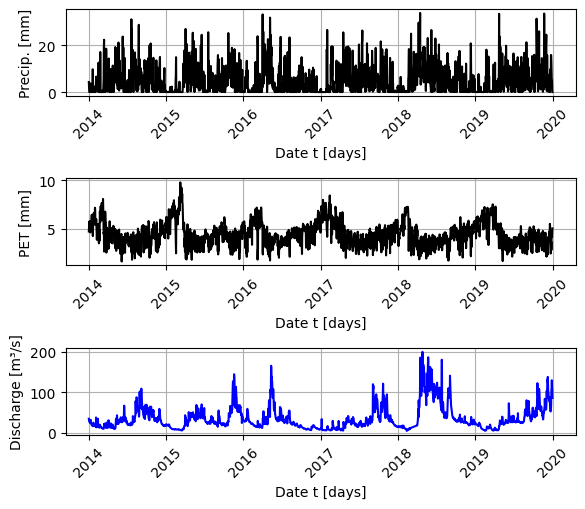

In [217]:
# Adjust image size
plt.figure(figsize=(6, 5.2))

# Analysis period: 1/1/2014 to 31/12/2019
start_date = '2014-01-01'
end_date = '2019-12-31'

# Example data (replace with your actual data)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a DataFrame with the first 2191 values
daily = pd.DataFrame({
    'pluie': data["PrecCHIRPS"].iloc[:2191].values,  # Example data for 'rainfall'
    'etp': data["ETrefMERRA2"].iloc[:2191].values,  # Example data for 'PET'
    'debit': data["Qcms"].iloc[:2191].values        # Example data for 'discharge'
}, index=date_range[:2191])  # Limit date range to 2191 days

# Period for X-axis ticks
start_year = 2014
end_year = 2020
years = list(range(start_year, end_year + 1))
ticks = pd.to_datetime([f'{year}-01-01' for year in years])

# Label for Y-axis
y_labels = {
    "debit": "Discharge [m³/s]",
    "pluie": "Precip. [mm]",
    "etp": "PET [mm]"
}

# Reorganize variables in the desired order: "rainfall", "PET", "discharge"
ordered_vars = ["pluie", "etp", "debit"]

# Plot each variable
for i, var in enumerate(ordered_vars):
    plt.subplot(len(ordered_vars), 1, i + 1)

    # Conditional color: blue for 'discharge', black for others
    color = 'blue' if var == "debit" else 'black'

    # Plot data
    plt.plot(daily.index, daily[var], color=color)

    # Set axis labels and titles
    plt.xlabel('Date t [days]')
    plt.ylabel(y_labels.get(var, var))

    # Add grid and adjust ticks
    plt.grid(True)
    plt.xticks(ticks=ticks, labels=[tick.year for tick in ticks], rotation=45)

# Use tight_layout to prevent overlap
plt.tight_layout()


plt.show()


In [218]:
max(data["Qcms"].iloc[:2191].values)

199.519

In [219]:
#Compute the Effective precipitation
prec_eff = prec - pet
prec_eff[prec_eff < 0] = 0

#State of the basin X(t)
def state_basin(MU, LANDA, q):
    n = len(q)
    X = np.zeros(n)
    X[0] = q[0]
    for i in range(1, n):
        if q[i] == 0:
            X[i] = X[i - 1] - (MU / LANDA) * X[i - 1]**(2*MU-1)
        else:
            X[i] = X[i - 1] + (MU / LANDA) * q[i]**(2*MU-1)
    return X

Heuristic method

In [220]:
# IMPORTANT: For the case of Yala river basin, the condition: if Qsim1[k-1]<0:, can be removed, as explained in the paper.
# We started with broad parameter ranges and then manually narrowed them down to maintain the  limits:
#mu = (1.2 - 1) * np.random.rand() + 1
#lambda_ = (108 - 104) * np.random.rand() + 104
#c = (2. - 1.8) * np.random.rand() + 1.8

nashe = 0
Qsim = np.zeros(len(discharge))
Qsim[0] = discharge[0]
Q1 = np.zeros(len(discharge))

for pp in range(100000):
      mu = (1.2 - 1) * np.random.rand() + 1
      lambda_ = (108 - 104) * np.random.rand() + 104
      c = (2. - 1.8) * np.random.rand() + 1.8

      y = state_basin(mu, lambda_, prec_eff)
      X = y**c

      for k in range(1, len(discharge)):
         # if Qsim[k - 1]<0:
         #    Qsim[k - 1] = 0
          Qsim[k] = Qsim[k-1] - (mu/lambda_) * Qsim[k-1]**(2*mu-1) + (1/lambda_) * X[k-1] * prec_eff[k-1]

      #Nsh criteria
      nas = nash_sutcliffe_efficiency(discharge, Qsim)
      if nashe < nas:
          nashe = nas
          mu_estimated = mu
          lambda_estimated = lambda_
          c_estimated = c

          Q_sim = Qsim.copy()


print(nashe)

0.5565636459217033


In [221]:
print(mu_estimated)
print(lambda_estimated)
print(c_estimated)

1.1534479900836982
107.9859708940374
1.8883899700631148


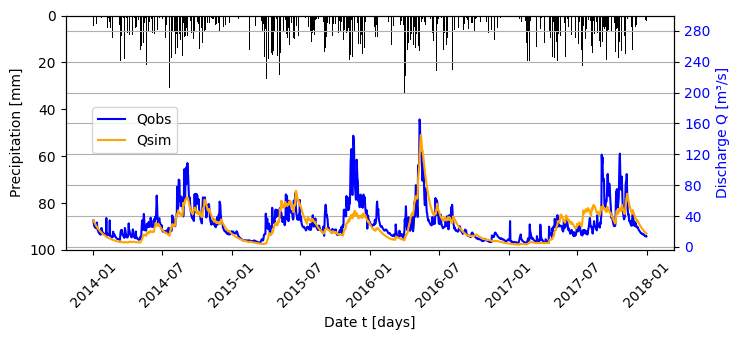

In [222]:
#PLOT

# Define date range
time1 = np.datetime64('2014-01-01')
time2 = np.datetime64('2017-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(7.5, 3.5))

# Plot precipitation histogram
ax1.bar(time, prec, color='black')

# Format x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
ax1.set_xlabel('Date t [days]')

# Configure y-axis for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create secondary y-axis for discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge, 'b', label='Qobs')  # Observed discharge
ax2.plot(time, Q_sim, 'orange', label='Qsim')    # Simulated discharge

# Configure y-axis for discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-4, 300)
ax2.set_yticks(np.arange(0, 301, 40))

# Add legend
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.7))

# Enable grid
plt.grid(True)

# Prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


VALIDATION

In [223]:
#Validation data
discharge1 = daily.iloc[1461:2191, 2].to_numpy()
prec1 = daily.iloc[1461:2191, 0].to_numpy()
pet1 = daily.iloc[1461:2191, 1].to_numpy()

In [224]:
#Compute the Effective precipitation
prec_eff1 = prec1 - pet1
prec_eff1[prec_eff1 < 0] = 0

In [225]:
#Basin state
y = state_basin(mu_estimated, lambda_estimated , prec_eff1)
X = y**c_estimated

#EQUATION
Qsim1 = np.zeros(len(discharge1))
Qsim1[0] = discharge1[0]
for k in range(1, len(discharge1)):

    Qsim1[k] = Qsim1[k-1] - (mu_estimated/lambda_estimated) * Qsim1[k-1]**(2*mu_estimated-1) + (1/lambda_estimated) * X[k-1] * prec_eff1[k-1]


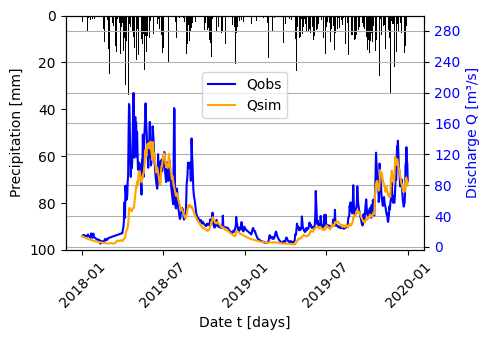

In [226]:
#PLOT

time1 = np.datetime64('2018-01-01')
time2 = np.datetime64('2019-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

fig, ax1 = plt.subplots(figsize=(5., 3.5))

# Plot a histogram for precipitation on axis ax1
ax1.bar(time, prec1, color='black')

# Format x-axis labels
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Use MonthLocator to set ticks every 6 months
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))  # January 1st, July 1st

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45)

ax1.set_xlabel('Date t [days]')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 20))

# Invert y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a secondary y-axis for discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge1, 'b', label='Qobs')

# Plot the mean trajectory
ax2.plot(time, Qsim1, 'orange', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge Q [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-4, 300)
ax2.set_yticks(np.arange(0, 300, 40))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.4, 0.8))

# Display the grid
plt.grid(True)

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Show the plot
plt.show()


In [227]:
#NSE metric for evaluating the predictive capacity of the model
nse_value = nash_sutcliffe_efficiency(discharge1, Qsim1)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

Nash-Sutcliffe Efficiency (NSE): 0.6716138379233527
